## Imports

In [1]:
import csv
import matplotlib.pyplot as plt

import numpy as np
import trompy as tp
from datetime import datetime
import pandas as pd
import pickle 

%matplotlib inline


from scipy import stats

In [2]:
def extract_event_fn(filename): 
    '''
    function to extract framenumber of events (licks and pump_on) in framenumber
    
    args
    filename - string 
    
    returns 
    licks_fn - lits of integers
        framenumber of licks
    pump_on_fn - list of integers 
        framenumber when pump turns on
    
    '''
    df= pd.read_csv(filename)
    
    #Extracts pump on framenumber
    pump_fn = list(df[df['Item1'] == 'pump_on']['Item2.Item2'])
    
    
    #Extracts licks framenumber
    licks_fn = list (df[df['Item1']== 'Lick']['Item2.Item2'])

      
    return pump_fn, licks_fn
        


In [3]:
def get_hit_miss_trial (pump_fn, licks_fn): 
    '''
    function to get hit and miss trials
    
    arg 
    pump_fn - list of integers
        framenumber for when the pump turns on 
    licks_fn - list of integers
        framenumber for all licks
    triallenght - int float (optional, default set to 100 frames (10sec))
    
    returns 
    hit_trial - list of int 
        pump on frame number in hit trials (lick > 0)
    miss_trial - list of int 
        pump on frame number in missed trials (lick = 0)
    
    '''
    hit_trial=[]
    miss_trial=[]
    for p in pump_fn: 
        temp=[]
        for lick in licks_fn: 
            if lick > p and lick < p + 100: 
                temp.append(lick)
            
        if len(temp)> 0:
            hit_trial.append(p)
        if len(temp) == 0: 
            miss_trial.append(p)
    return hit_trial, miss_trial

In [4]:
def get_licks_trial (pump_fn, licks_fn, triallength=100):
    '''
    function to get licks within one trial 
    licks aligned to pump on (pump_fn)
    
    arg 
    pump_fn - list of integers
        framenumber for when the pump turns on 
    licks_fn - list of integers
        framenumber for all licks
    triallenght - int float (optional, default set to 100 frames (10sec))
    
    returns 
    licks_trial - list of list of integers
        list of all licks in all trials aligned to pump on (in frames)
    licks_all_trial - list of integers
        number of licks of each trial 
    licks_hit_trial - list of integers 
        number of licks per trial for hit trials 
    latency - list of integers
        latency to first lick after pump on (in frames)
        
    
    '''

    # All licks aligned to pump on 
    licks_trial=[]
    for p in pump_fn:
        temp=[]
        for lick in licks_fn: 
            if lick > p and lick < p + 100:
                temp.append(lick - p)
        licks_trial.append(temp)
        
        
    #licks per trial (all and hit trials) aligned to pump on 
    licks_all_trial=[]
    licks_hit_trial=[]
    for trial in licks_trial: 
        licks_all_trial.append(len(trial))
        if len(trial) > 0: 
            licks_hit_trial.append(len(trial))
            
            
    #Latency to first lick after pump on
    temp_latency=[]
    for trial in licks_trial:
        if len(trial) > 0: 
            temp_latency.append(trial[:1])
    
    latency=[trial for sublist in temp_latency for trial in sublist] #List comprehension to convert list of lists to flat list     
            
        
    return licks_trial, licks_all_trial, licks_hit_trial, latency

## Metafile reader

In [5]:
rows,header=tp.metafilereader('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Metafile_VGP2.2.xls',sheetname='Behavior')
# rows_homecage,header=tp.metafilereader('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Metafile_VGP2.2.xls',sheetname='Homecage')
folder= 'C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\VGP2\\Bonsai\\'

File is excel file. Making csv metafile first


## Dictionary

In [6]:
all_data={}

for row in rows: 
    try:
        key=row[0]+ '_' + row[4]
    
        pump_fn, licks_fn = extract_event_fn(folder+row[1])
        hit_trial, miss_trial = get_hit_miss_trial(pump_fn, licks_fn)
        licks_trial, licks_all_trial, licks_hit_trial, latency = get_licks_trial(pump_fn, licks_fn)
        
    
        all_data[key]={}

        all_data[key]['mouse']=row[0]
        all_data[key]['diet']=row[7]
        all_data[key]['solution']=row[8]
    
#         all_data[key]['file']=row[1]
        all_data[key]['licks_fn']= licks_fn
        all_data[key]['pump_fn']= pump_fn
        all_data[key]['licks trial']= licks_trial
        all_data[key]['number of trials']=len(pump_fn)
        all_data[key]['total licks']=len(licks_fn)
        all_data[key]['hit trial'] = len(hit_trial)
        all_data[key]['miss trials']= len(miss_trial)
        all_data[key]['licks per trial']= np.mean(licks_all_trial)
        all_data[key]['licks hit trial']= np.mean(licks_hit_trial)
        all_data[key]['latency']= np.mean(latency)
    
    except FileNotFoundError: 
        print('Cannot find file for', key)

In [7]:

with open('..//output//behavdata.pickle', 'wb') as file:
    pickle.dump(all_data, file, protocol=pickle.HIGHEST_PROTOCOL)

with open('..//output//behavdata.pickle', 'rb') as file:
    b = pickle.load(file)

# Making groups and figures

In [49]:
mice=[]

for key in all_data.keys(): 
    d=all_data[key]
    mouseid=d['mouse']
    if mouseid not in mice: mice.append(mouseid)


for m in mice: 
    if m == 'VGP305':
        mice.remove(m)
mice

['VGP118',
 'VGP202',
 'VGP203',
 'VGP204',
 'VGP302',
 'VGP310',
 'VGP306',
 'VGP307']

## Total number of licks

Baseline

In [50]:
baseline_NR=[]
baseline_PR=[]

for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Baseline'and d['diet']== 'PR':
            temp_PR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Baseline' and d['diet']== 'NR':
            temp_NR.append(d['total licks'])

                
    if len(temp_PR)> 0:
        baseline_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        baseline_NR.append(np.mean(temp_NR))

In [51]:
print('PR',baseline_PR)
print('NR',baseline_NR)

PR [309.3333333333333, 626.3333333333334, 1617.3333333333333, 1008.6666666666666, 1933.0]
NR [704.0, 339.6666666666667, 927.0]


Ensure

In [52]:
ensure_NR=[]
ensure_PR=[]

ensure_NRPR=[]
ensure_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Ensure'and d['diet']== 'PR':
            temp_PR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'NR':
            temp_NR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'PRNR':
            temp_PRNR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'NRPR':
            temp_NRPR.append(d['total licks'])

                
    if len(temp_PR)> 0:
        ensure_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        ensure_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        ensure_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        ensure_NRPR.append(np.mean(temp_NRPR))

In [53]:
print('PR',ensure_PR)
print('PRNR', ensure_PRNR)
print('  ')
print('NR',ensure_NR)
print('NRPR', ensure_NRPR)

PR [562.3333333333334, 376.3333333333333, 505.6666666666667, 711.6666666666666, 1389.0]
PRNR [744.3333333333334, 276.0, 485.0, 597.6666666666666, 969.0]
  
NR [122.33333333333333, 280.6666666666667, 453.0]
NRPR [472.6666666666667, 749.6666666666666, 623.3333333333334]


Casein

In [54]:
cas_NR=[]
cas_PR=[]

cas_NRPR=[]
cas_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Cas'and d['diet']== 'PR':
            temp_PR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NR':
            temp_NR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'PRNR':
            temp_PRNR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NRPR':
            temp_NRPR.append(d['total licks'])

                
    if len(temp_PR)> 0:
        cas_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        cas_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        cas_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        cas_NRPR.append(np.mean(temp_NRPR))

In [55]:
print('PR',cas_PR)
print('PRNR', cas_PRNR)
print('  ')
print('NR',cas_NR)
print('NRPR', cas_NRPR)

PR [289.3333333333333, 233.66666666666666, 306.3333333333333, 350.0, 427.3333333333333]
PRNR [663.0, 258.6666666666667, 334.5, 200.0, 171.5]
  
NR [133.66666666666666, 144.0, 236.66666666666666]
NRPR [241.0, 345.3333333333333, 506.5]


Maltodextrin

In [56]:
malt_NR=[]
malt_PR=[]

malt_NRPR=[]
malt_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Malt.'and d['diet']== 'PR':
            temp_PR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'NR':
            temp_NR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'PRNR':
            temp_PRNR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'NRPR':
            temp_NRPR.append(d['total licks'])

                
    if len(temp_PR)> 0:
        malt_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        malt_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        malt_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        malt_NRPR.append(np.mean(temp_NRPR))

In [57]:
print('PR', malt_PR)
print('PRNR', malt_PRNR)
print('  ')
print('NR', malt_NR)
print('NRPR', malt_NRPR)

PR [274.6666666666667, 146.0, 222.33333333333334, 414.3333333333333, 328.0]
PRNR [457.0, 204.66666666666666, 225.5, 265.5, 243.0]
  
NR [209.0, 222.5, 205.33333333333334]
NRPR [207.33333333333334, 235.66666666666666, 134.0]


## Figures

Ensure

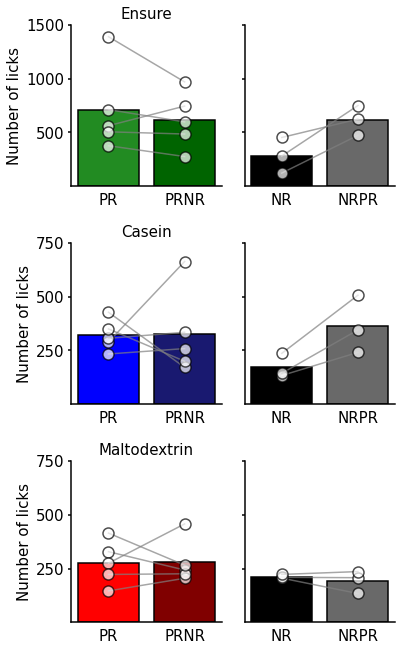

In [61]:
PR_E=['forestgreen','darkgreen']
PR_C=['b','midnightblue']
PR_M=['r','maroon']
NR=['black','dimgray']

f,ax=plt.subplots(figsize=(6,10), ncols=2, nrows=3, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.15)

#Ensure
tp.barscatter([ensure_PR,ensure_PRNR], 
              paired= True,
              barfacecolor=PR_E,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[0,0])

tp.barscatter([ensure_NR,ensure_NRPR], 
              paired= True,
              barfacecolor=NR,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[0,1])
#casein

tp.barscatter([cas_PR,cas_PRNR], 
              paired= True,
              barfacecolor=PR_C,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[1,0])

tp.barscatter([cas_NR,cas_NRPR], 
              paired= True,
              barfacecolor=NR,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[1,1])

#maltodextrin

tp.barscatter([malt_PR,malt_PRNR], 
              paired= True,
              barfacecolor=PR_M,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[2,0])

tp.barscatter([malt_NR,malt_NRPR], 
              paired= True,
              barfacecolor=NR,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[2,1])



ax[0,0].set_ylabel('Number of licks',fontsize = 15)
ax[0,0].set_yticks([500,1000,1500])
ax[0,1].set_yticks([500,1000,1500])
ax[0,0].set_yticklabels([500,1000,1500], fontsize = 15)

ax[1,0].set_ylabel('Number of licks',fontsize = 15)
ax[1,0].set_yticks([250,500,750])
ax[1,1].set_yticks([250,500,750])
ax[1,0].set_yticklabels([250,500,750], fontsize = 15)

ax[2,0].set_ylabel('Number of licks',fontsize = 15)
ax[2,0].set_yticks([250,500,750])
ax[2,1].set_yticks([250,500,750])
ax[2,0].set_yticklabels([250,500,750], fontsize = 15)

ax[0,0].set_title('Ensure', fontsize =15)
ax[1,0].set_title('Casein', fontsize =15)
ax[2,0].set_title('Maltodextrin', fontsize =15)




f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\Total_licks.png')

In [62]:
ppaired_NR=[]
ppaired_PR=[]

ppaired_NRPR=[]
ppaired_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='ppaired'and d['diet']== 'PR':
            temp_PR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='ppaired' and d['diet']== 'NR':
            temp_NR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='ppaired' and d['diet']== 'PRNR':
            temp_PRNR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='ppaired' and d['diet']== 'NRPR':
            temp_NRPR.append(d['total licks'])

                
    if len(temp_PR)> 0:
        ppaired_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        ppaired_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        ppaired_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        ppaired_NRPR.append(np.mean(temp_NRPR))
        
print('PR', ppaired_PR)
print('PRNR', ppaired_PRNR)
print('  ')
print('NR', ppaired_NR)
print('NRPR', ppaired_NRPR)

PR [385.0, 126.0, 477.0, 412.0, 277.0]
PRNR [355.0, 155.0, 294.0, 320.0]
  
NR [261.0, 195.0, 109.0]
NRPR [269.0, 241.0, 180.0]


In [63]:
mpaierd_NR=[]
mpaierd_PR=[]

mpaierd_NRPR=[]
mpaierd_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='mpaired'and d['diet']== 'PR':
            temp_PR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='mpaired' and d['diet']== 'NR':
            temp_NR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='mpaired' and d['diet']== 'PRNR':
            temp_PRNR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='mpaired' and d['diet']== 'NRPR':
            temp_NRPR.append(d['total licks'])

                
    if len(temp_PR)> 0:
        mpaierd_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        mpaierd_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        mpaierd_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        mpaierd_NRPR.append(np.mean(temp_NRPR))
        
print('PR', mpaierd_PR)
print('PRNR', mpaierd_PRNR)
print('  ')
print('NR', mpaierd_NR)
print('NRPR', mpaierd_NRPR)

PR [243.0, 174.0, 177.0, 373.0, 406.0]
PRNR [321.0, 31.0, 263.0, 346.0, 416.0]
  
NR [355.0, 195.0, 210.0]
NRPR [304.0, 171.0, 147.0]


Could not space all sets of points.
Could not space all sets of points.


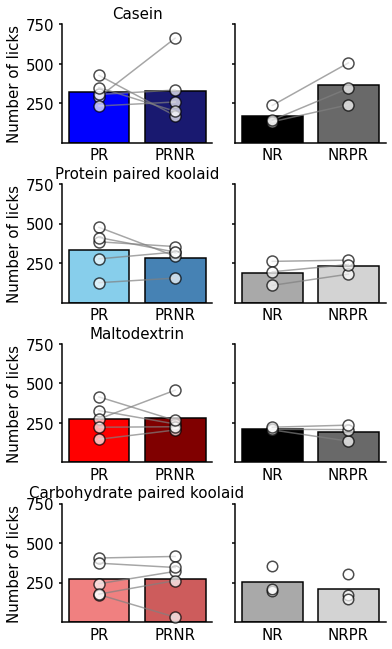

In [65]:
PR_C=['b','midnightblue']
PR_PP=[ 'skyblue','steelblue']
PR_M=['r','maroon']
PR_MP=['lightcoral','indianred']
NR=['black','dimgray']
NR_P=['darkgrey','lightgrey']

f,ax=plt.subplots(figsize=(6,10), ncols=2, nrows=4, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.15)

#Ensure
tp.barscatter([cas_PR,cas_PRNR], 
              paired= True,
              barfacecolor=PR_C,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[0,0])

tp.barscatter([cas_NR,cas_NRPR], 
              paired= True,
              barfacecolor=NR,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[0,1])
#protein paired

tp.barscatter([ppaired_PR,ppaired_PRNR], 
              paired= True,
              barfacecolor=PR_PP,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[1,0])

tp.barscatter([ppaired_NR,ppaired_NRPR], 
              paired= True,
              barfacecolor=NR_P,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[1,1])

#maltodextrin

tp.barscatter([malt_PR,malt_PRNR], 
              paired= True,
              barfacecolor=PR_M,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[2,0])

tp.barscatter([malt_NR,malt_NRPR], 
              paired= True,
              barfacecolor=NR,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[2,1])


#Maltodextrin paired

tp.barscatter([mpaierd_PR,mpaierd_PRNR], 
              paired= True,
              barfacecolor=PR_MP,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[3,0])

tp.barscatter([mpaierd_NR,mpaierd_NRPR], 
#               paired= True,
              barfacecolor=NR_P,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[3,1])

ax[0,0].set_ylabel('Number of licks',fontsize = 15)
ax[0,0].set_yticks([250,500,750])
ax[0,1].set_yticks([250,500,750])
ax[0,0].set_yticklabels([250,500,750], fontsize = 15)

ax[1,0].set_ylabel('Number of licks',fontsize = 15)
ax[1,0].set_yticks([250,500,750])
ax[1,1].set_yticks([250,500,750])
ax[1,0].set_yticklabels([250,500,750], fontsize = 15)

ax[2,0].set_ylabel('Number of licks',fontsize = 15)
ax[2,0].set_yticks([250,500,750])
ax[2,1].set_yticks([250,500,750])
ax[2,0].set_yticklabels([250,500,750], fontsize = 15)

ax[3,0].set_ylabel('Number of licks',fontsize = 15)
ax[3,0].set_yticks([250,500,750])
ax[3,1].set_yticks([250,500,750])
ax[3,0].set_yticklabels([250,500,750], fontsize = 15)

ax[0,0].set_title('Casein', fontsize =15)
ax[1,0].set_title('Protein paired koolaid', fontsize =15)
ax[2,0].set_title('Maltodextrin', fontsize =15)
ax[3,0].set_title('Carbohydrate paired koolaid', fontsize =15)



f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\Total_licks_koolaid.png')

## Licks per trial (all)

Baseline

In [21]:
baseline_NR=[]
baseline_PR=[]

for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Baseline'and d['diet']== 'PR':
            temp_PR.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Baseline' and d['diet']== 'NR':
            temp_NR.append(d['licks per trial'])

                
    if len(temp_PR)> 0:
        baseline_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        baseline_NR.append(np.mean(temp_NR))

In [22]:
print('PR',baseline_PR)
print('NR',baseline_NR)

PR [2.7579476756306023, 7.543081543081542, 19.995951417004047, 10.494548087571344, 21.53663375919474]
NR [10.444512195121952, 3.9015969410706255, 13.028693528693529, 10.949343339587243]


Ensure

In [23]:
ensure_NR=[]
ensure_PR=[]

ensure_NRPR=[]
ensure_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Ensure'and d['diet']== 'PR':
            temp_PR.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'NR':
            temp_NR.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'PRNR':
            temp_PRNR.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'NRPR':
            temp_NRPR.append(d['licks per trial'])

                
    if len(temp_PR)> 0:
        ensure_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        ensure_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        ensure_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        ensure_NRPR.append(np.mean(temp_NRPR))
        
print('PR',ensure_PR)
print('PRNR', ensure_PRNR)
print('  ')
print('NR',ensure_NR)
print('NRPR', ensure_NRPR)

PR [6.975770218228498, 3.8492424242424246, 5.508072753804462, 8.010920177383591, 15.44890943575154]
PRNR [9.738633982820028, 2.4134146341463416, 6.346690590111643, 8.065740740740742, 15.108396858396858]
  
NR [1.2965645821871752, 4.117405867405867, 1.5190382081686427, 5.10534188034188]
NRPR [5.859744120613686, 11.449561403508772, 8.755578139114723]


Casein

In [24]:
cas_NR=[]
cas_PR=[]

cas_NRPR=[]
cas_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Cas'and d['diet']== 'PR':
            temp_PR.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NR':
            temp_NR.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'PRNR':
            temp_PRNR.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NRPR':
            temp_NRPR.append(d['licks per trial'])

                
    if len(temp_PR)> 0:
        cas_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        cas_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        cas_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        cas_NRPR.append(np.mean(temp_NRPR))
        
        
print('PR',cas_PR)
print('PRNR', cas_PRNR)
print('  ')
print('NR',cas_NR)
print('NRPR', cas_NRPR)

PR [2.7364522417153996, 2.3086303939962476, 2.900877192982456, 4.231435231435231, 4.978778883183568]
PRNR [7.753508771929824, 2.4960156802262063, 3.625779625779626, 5.280555555555555, 1.7402027027027027]
  
NR [1.200404858299595, 1.2601779317604616, 4.192582005082006, 2.537626116573485]
NRPR [3.005430242272347, 5.448717948717949, 7.268537768537769]


Maltodextrin

In [25]:
malt_NR=[]
malt_PR=[]

malt_NRPR=[]
malt_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Malt.'and d['diet']== 'PR':
            temp_PR.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'NR':
            temp_NR.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'PRNR':
            temp_PRNR.append(d['licks per trial'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'NRPR':
            temp_NRPR.append(d['licks per trial'])

                
    if len(temp_PR)> 0:
        malt_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        malt_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        malt_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        malt_NRPR.append(np.mean(temp_NRPR))
        
print('PR', malt_PR)
print('PRNR', malt_PRNR)
print('  ')
print('NR', malt_NR)
print('NRPR', malt_NRPR)

PR [3.5341130604288495, 1.5707317073170735, 2.482905982905983, 3.9434542422347296, 2.9451754385964914]
PRNR [4.4558060084375875, 2.1532677848467325, 1.5964714714714714, 2.569337979094077, 2.8080745341614906]
  
NR [1.5737080103359176, 2.361788617886179, 2.8011088011088012, 2.230958230958231]
NRPR [1.896049896049896, 1.7040791187132651, 1.04800853485064]


## Figures licks per trial

Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


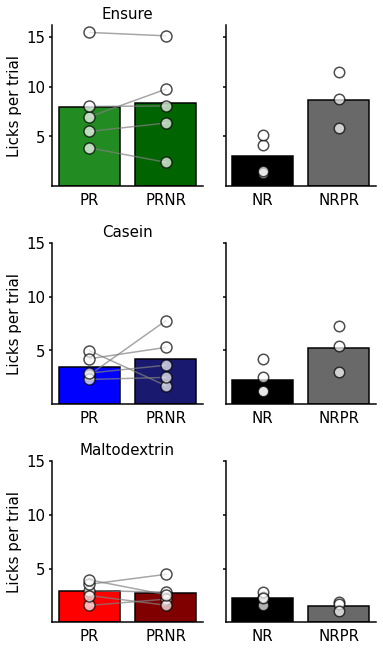

In [26]:
PR_E=['forestgreen','darkgreen']
PR_C=['b','midnightblue']
PR_M=['r','maroon']
NR=['black','dimgray']

f,ax=plt.subplots(figsize=(6,10), ncols=2, nrows=3, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.15)

#Ensure
tp.barscatter([ensure_PR,ensure_PRNR], 
              paired= True,
              barfacecolor=PR_E,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[0,0])

tp.barscatter([ensure_NR,ensure_NRPR], 
#               paired= True,
              barfacecolor=NR,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[0,1])
#casein

tp.barscatter([cas_PR,cas_PRNR], 
              paired= True,
              barfacecolor=PR_C,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[1,0])

tp.barscatter([cas_NR,cas_NRPR], 
#               paired= True,
              barfacecolor=NR,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[1,1])

#maltodextrin

tp.barscatter([malt_PR,malt_PRNR], 
              paired= True,
              barfacecolor=PR_M,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[2,0])

tp.barscatter([malt_NR,malt_NRPR], 
#               paired= True,
              barfacecolor=NR,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[2,1])



ax[0,0].set_ylabel('Licks per trial',fontsize = 15)
ax[0,0].set_yticks([5,10,15])
ax[0,1].set_yticks([5,10,15])
ax[0,0].set_yticklabels([5,10,15], fontsize = 15)

ax[1,0].set_ylabel('Licks per trial',fontsize = 15)
ax[1,0].set_yticks([5,10,15])
ax[1,1].set_yticks([5,10,15])
ax[1,0].set_yticklabels([5,10,15], fontsize = 15)

ax[2,0].set_ylabel('Licks per trial',fontsize = 15)
ax[2,0].set_yticks([5,10,15])
ax[2,1].set_yticks([5,10,15])
ax[2,0].set_yticklabels([5,10,15], fontsize = 15)

ax[0,0].set_title('Ensure', fontsize =15)
ax[1,0].set_title('Casein', fontsize =15)
ax[2,0].set_title('Maltodextrin', fontsize =15)

f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\Licks_trial.png')

## Licks per trial hit trials

In [27]:
baseline_NR=[]
baseline_PR=[]

for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Baseline'and d['diet']== 'PR':
            temp_PR.append(d['licks hit trial'])
        elif d['mouse']==mouse and d['solution']=='Baseline' and d['diet']== 'NR':
            temp_NR.append(d['licks hit trial'])

                
    if len(temp_PR)> 0:
        baseline_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        baseline_NR.append(np.mean(temp_NR))

In [28]:
print('PR',baseline_PR)
print('NR',baseline_NR)

PR [4.08641975308642, 8.44114032709858, 20.711752353857616, 11.356027170661315, 24.045321637426905]
NR [10.862369337979095, 6.069187675070029, 15.00562851782364, 11.154471544715447]


Ensure

In [29]:
ensure_NR=[]
ensure_PR=[]

ensure_NRPR=[]
ensure_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Ensure'and d['diet']== 'PR':
            temp_PR.append(d['licks hit trial'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'NR':
            temp_NR.append(d['licks hit trial'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'PRNR':
            temp_PRNR.append(d['licks hit trial'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'NRPR':
            temp_NRPR.append(d['licks hit trial'])

                
    if len(temp_PR)> 0:
        ensure_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        ensure_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        ensure_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        ensure_NRPR.append(np.mean(temp_NRPR))
        
print('PR',ensure_PR)
print('PRNR', ensure_PRNR)
print('  ')
print('NR',ensure_NR)
print('NRPR', ensure_NRPR)

PR [9.171546546546548, 7.606658257845048, 8.885560385560387, 8.201829268292682, 16.531760435571687]
PRNR [9.738633982820028, 13.712962962962964, 8.501465201465201, 9.661494061494063, 16.097418373280444]
  
NR [3.8083333333333336, 5.354166666666667, 4.697826086956522, 6.844874828745797]
NRPR [7.7681461352657, 11.935672514619883, 10.077053646880556]


Casein

In [30]:
cas_NR=[]
cas_PR=[]

cas_NRPR=[]
cas_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Cas'and d['diet']== 'PR':
            temp_PR.append(d['licks hit trial'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NR':
            temp_NR.append(d['licks hit trial'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'PRNR':
            temp_PRNR.append(d['licks hit trial'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NRPR':
            temp_NRPR.append(d['licks hit trial'])

                
    if len(temp_PR)> 0:
        cas_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        cas_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        cas_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        cas_NRPR.append(np.mean(temp_NRPR))
        
        
print('PR',cas_PR)
print('PRNR', cas_PRNR)
print('  ')
print('NR',cas_NR)
print('NRPR', cas_NRPR)

PR [5.608477011494252, 6.854166666666667, 7.336161387631976, 6.3999999999999995, 7.684247076023392]
PRNR [8.249072602013777, 10.275757575757575, 5.343453510436433, 7.75, 3.8143939393939394]
  
NR [3.5944444444444446, 4.333333333333333, 6.248917748917748, 6.441245421245422]
NRPR [6.971104231166151, 6.798174048174048, 9.370303030303031]


Maltodextrin

In [31]:
malt_NR=[]
malt_PR=[]

malt_NRPR=[]
malt_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Malt.'and d['diet']== 'PR':
            temp_PR.append(d['licks hit trial'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'NR':
            temp_NR.append(d['licks hit trial'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'PRNR':
            temp_PRNR.append(d['licks hit trial'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'NRPR':
            temp_NRPR.append(d['licks hit trial'])

                
    if len(temp_PR)> 0:
        malt_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        malt_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        malt_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        malt_NRPR.append(np.mean(temp_NRPR))
        
print('PR', malt_PR)
print('PRNR', malt_PRNR)
print('  ')
print('NR', malt_NR)
print('NRPR', malt_NRPR)

PR [6.581730769230769, 4.188453159041394, 7.120370370370371, 6.762183235867446, 8.713578088578089]
PRNR [6.244324970131422, 4.674603174603175, 4.5625, 5.75, 5.846153846153847]
  
NR [3.3928872053872055, 7.0643939393939394, 8.26010101010101, 6.591025641025641]
NRPR [4.454761904761905, 3.425213675213675, 5.375]


## Figures licks per trial

Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


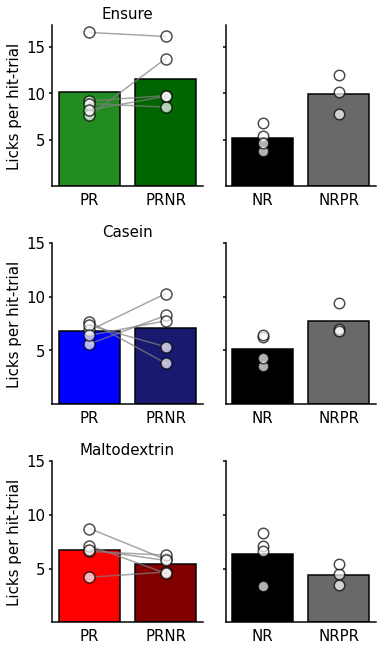

In [32]:
PR_E=['forestgreen','darkgreen']
PR_C=['b','midnightblue']
PR_M=['r','maroon']
NR=['black','dimgray']

f,ax=plt.subplots(figsize=(6,10), ncols=2, nrows=3, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.15)

#Ensure
tp.barscatter([ensure_PR,ensure_PRNR], 
              paired= True,
              barfacecolor=PR_E,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[0,0])

tp.barscatter([ensure_NR,ensure_NRPR], 
#               paired= True,
              barfacecolor=NR,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[0,1])
#casein

tp.barscatter([cas_PR,cas_PRNR], 
              paired= True,
              barfacecolor=PR_C,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[1,0])

tp.barscatter([cas_NR,cas_NRPR], 
#               paired= True,
              barfacecolor=NR,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[1,1])

#maltodextrin

tp.barscatter([malt_PR,malt_PRNR], 
              paired= True,
              barfacecolor=PR_M,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[2,0])

tp.barscatter([malt_NR,malt_NRPR], 
#               paired= True,
              barfacecolor=NR,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[2,1])



ax[0,0].set_ylabel('Licks per hit-trial',fontsize = 15)
ax[0,0].set_yticks([5,10,15])
ax[0,1].set_yticks([5,10,15])
ax[0,0].set_yticklabels([5,10,15], fontsize = 15)

ax[1,0].set_ylabel('Licks per hit-trial',fontsize = 15)
ax[1,0].set_yticks([5,10,15])
ax[1,1].set_yticks([5,10,15])
ax[1,0].set_yticklabels([5,10,15], fontsize = 15)

ax[2,0].set_ylabel('Licks per hit-trial',fontsize = 15)
ax[2,0].set_yticks([5,10,15])
ax[2,1].set_yticks([5,10,15])
ax[2,0].set_yticklabels([5,10,15], fontsize = 15)

ax[0,0].set_title('Ensure', fontsize =15)
ax[1,0].set_title('Casein', fontsize =15)
ax[2,0].set_title('Maltodextrin', fontsize =15)

f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\Licks_hit_trial.png')

## Number of hit trials

In [33]:
baseline_NR=[]
baseline_PR=[]

for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Baseline'and d['diet']== 'PR':
            temp_PR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Baseline' and d['diet']== 'NR':
            temp_NR.append(d['hit trial'])

                
    if len(temp_PR)> 0:
        baseline_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        baseline_NR.append(np.mean(temp_NR))

In [34]:
print('PR',baseline_PR)
print('NR',baseline_NR)

PR [27.0, 33.333333333333336, 36.666666666666664, 36.333333333333336, 36.666666666666664]
NR [31.333333333333332, 18.0, 29.666666666666668, 39.0]


Ensure

In [35]:
ensure_NR=[]
ensure_PR=[]

ensure_NRPR=[]
ensure_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Ensure'and d['diet']== 'PR':
            temp_PR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'NR':
            temp_NR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'PRNR':
            temp_PRNR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'NRPR':
            temp_NRPR.append(d['hit trial'])

                
    if len(temp_PR)> 0:
        ensure_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        ensure_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        ensure_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        ensure_NRPR.append(np.mean(temp_NRPR))
        
print('PR',ensure_PR)
print('PRNR', ensure_PRNR)
print('  ')
print('NR',ensure_NR)
print('NRPR', ensure_NRPR)

PR [26.333333333333332, 21.0, 24.0, 40.333333333333336, 35.0]
PRNR [39.333333333333336, 7.666666666666667, 29.0, 28.333333333333332, 35.0]
  
NR [12.333333333333334, 22.333333333333332, 15.666666666666666, 27.333333333333332]
NRPR [31.0, 35.333333333333336, 36.0]


Casein

In [36]:
cas_NR=[]
cas_PR=[]

cas_NRPR=[]
cas_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Cas'and d['diet']== 'PR':
            temp_PR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NR':
            temp_NR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'PRNR':
            temp_PRNR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NRPR':
            temp_NRPR.append(d['hit trial'])

                
    if len(temp_PR)> 0:
        cas_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        cas_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        cas_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        cas_NRPR.append(np.mean(temp_NRPR))
        
        
print('PR',cas_PR)
print('PRNR', cas_PRNR)
print('  ')
print('NR',cas_NR)
print('NRPR', cas_NRPR)

PR [17.666666666666668, 12.666666666666666, 15.333333333333334, 21.333333333333332, 22.0]
PRNR [38.666666666666664, 9.666666666666666, 24.0, 10.5, 17.0]
  
NR [11.333333333333334, 12.333333333333334, 19.0, 17.333333333333332]
NRPR [17.0, 29.666666666666668, 29.0]


Maltodextrin

In [37]:
malt_NR=[]
malt_PR=[]

malt_NRPR=[]
malt_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Malt.'and d['diet']== 'PR':
            temp_PR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'NR':
            temp_NR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'PRNR':
            temp_PRNR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'NRPR':
            temp_NRPR.append(d['hit trial'])

                
    if len(temp_PR)> 0:
        malt_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        malt_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        malt_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        malt_NRPR.append(np.mean(temp_NRPR))
        
print('PR', malt_PR)
print('PRNR', malt_PRNR)
print('  ')
print('NR', malt_NR)
print('NRPR', malt_NRPR)

PR [18.666666666666668, 12.666666666666666, 14.0, 23.333333333333332, 14.333333333333334]
PRNR [27.333333333333332, 19.0, 13.5, 19.5, 16.5]
  
NR [18.666666666666668, 17.0, 14.5, 13.333333333333334]
NRPR [16.0, 21.0, 11.5]


## Figures licks per trial

Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


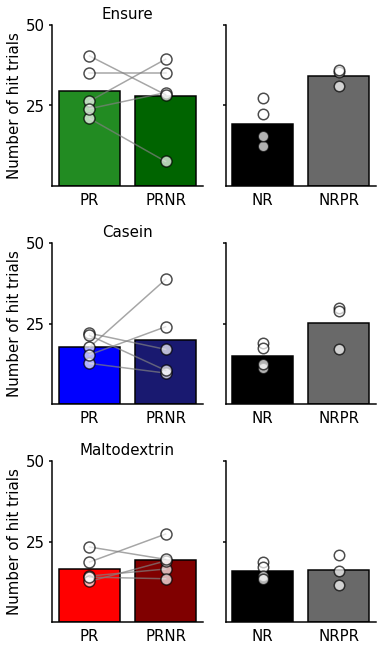

In [38]:
PR_E=['forestgreen','darkgreen']
PR_C=['b','midnightblue']
PR_M=['r','maroon']
NR=['black','dimgray']

f,ax=plt.subplots(figsize=(6,10), ncols=2, nrows=3, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.15)

#Ensure
tp.barscatter([ensure_PR,ensure_PRNR], 
              paired= True,
              barfacecolor=PR_E,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[0,0])

tp.barscatter([ensure_NR,ensure_NRPR], 
#               paired= True,
              barfacecolor=NR,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[0,1])
#casein

tp.barscatter([cas_PR,cas_PRNR], 
              paired= True,
              barfacecolor=PR_C,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[1,0])

tp.barscatter([cas_NR,cas_NRPR], 
#               paired= True,
              barfacecolor=NR,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[1,1])

#maltodextrin

tp.barscatter([malt_PR,malt_PRNR], 
              paired= True,
              barfacecolor=PR_M,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[2,0])

tp.barscatter([malt_NR,malt_NRPR], 
#               paired= True,
              barfacecolor=NR,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[2,1])



ax[0,0].set_ylabel('Number of hit trials',fontsize = 15)
ax[0,0].set_yticks([25,50])
ax[0,1].set_yticks([25,50])
ax[0,0].set_yticklabels([25,50], fontsize = 15)

ax[1,0].set_ylabel('Number of hit trials',fontsize = 15)
ax[1,0].set_yticks([25,50])
ax[1,1].set_yticks([25,50])
ax[1,0].set_yticklabels([25,50], fontsize = 15)

ax[2,0].set_ylabel('Number of hit trials',fontsize = 15)
ax[2,0].set_yticks([25,50])
ax[2,1].set_yticks([25,50])
ax[2,0].set_yticklabels([25,50], fontsize = 15)

ax[0,0].set_title('Ensure', fontsize =15)
ax[1,0].set_title('Casein', fontsize =15)
ax[2,0].set_title('Maltodextrin', fontsize =15)


f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\hit_trial.png')

## Latency to first lick

In [39]:
baseline_NR=[]
baseline_PR=[]

for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Baseline'and d['diet']== 'PR':
            temp_PR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Baseline' and d['diet']== 'NR':
            temp_NR.append(d['latency'])

                
    if len(temp_PR)> 0:
        baseline_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        baseline_NR.append(np.mean(temp_NR))

In [40]:
print('PR',baseline_PR)
print('NR',baseline_NR)

PR [28.75308641975309, 23.156555525435977, 22.979468942626838, 22.08265934607398, 19.81091617933723]
NR [23.3158670597695, 35.688795518207286, 29.271419637273297, 20.188061617458278]


Ensure

In [41]:
ensure_NR=[]
ensure_PR=[]

ensure_NRPR=[]
ensure_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Ensure'and d['diet']== 'PR':
            temp_PR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'NR':
            temp_NR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'PRNR':
            temp_PRNR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Ensure' and d['diet']== 'NRPR':
            temp_NRPR.append(d['latency'])

                
    if len(temp_PR)> 0:
        ensure_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        ensure_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        ensure_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        ensure_NRPR.append(np.mean(temp_NRPR))
        
print('PR',ensure_PR)
print('PRNR', ensure_PRNR)
print('  ')
print('NR',ensure_NR)
print('NRPR', ensure_NRPR)

PR [28.44069069069069, 29.86538241027405, 23.093177093177093, 26.507723577235776, 19.030550514216575]
PRNR [26.597423004399747, 29.88888888888889, 29.407692307692304, 28.07794427794428, 20.378736827012688]
  
NR [29.8, 37.53402777777777, 34.81594202898551, 23.77977747332586]
NRPR [31.951992753623188, 26.547953216374268, 26.32146603724102]


Casein

In [42]:
cas_NR=[]
cas_PR=[]

cas_NRPR=[]
cas_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Cas'and d['diet']== 'PR':
            temp_PR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NR':
            temp_NR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'PRNR':
            temp_PRNR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Cas' and d['diet']== 'NRPR':
            temp_NRPR.append(d['latency'])

                
    if len(temp_PR)> 0:
        cas_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        cas_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        cas_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        cas_NRPR.append(np.mean(temp_NRPR))
        
        
print('PR',cas_PR)
print('PRNR', cas_PRNR)
print('  ')
print('NR',cas_NR)
print('NRPR', cas_NRPR)

PR [35.41020114942528, 34.125, 33.15299773755657, 40.4324074074074, 29.187207602339182]
PRNR [31.890902667373258, 30.24848484848485, 42.02182163187856, 27.39285714285714, 37.36363636363636]
  
NR [28.191666666666666, 44.989417989417994, 33.705627705627705, 27.41956043956044]
NRPR [39.520880632954935, 38.17266067266067, 27.316363636363636]


Maltodextrin

In [43]:
malt_NR=[]
malt_PR=[]

malt_NRPR=[]
malt_PRNR=[]


for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    temp_NRPR=[]
    temp_PRNR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Malt.'and d['diet']== 'PR':
            temp_PR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'NR':
            temp_NR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'PRNR':
            temp_PRNR.append(d['hit trial'])
        elif d['mouse']==mouse and d['solution']=='Malt.' and d['diet']== 'NRPR':
            temp_NRPR.append(d['latency'])

                
    if len(temp_PR)> 0:
        malt_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        malt_NR.append(np.mean(temp_NR))
    if len(temp_PRNR)>0:
        malt_PRNR.append(np.mean(temp_PRNR))
    if len(temp_NRPR)>0:
        malt_NRPR.append(np.mean(temp_NRPR))
        
print('PR', malt_PR)
print('PRNR', malt_PRNR)
print('  ')
print('NR', malt_NR)
print('NRPR', malt_NRPR)

PR [27.145146520146522, 40.031590413943356, 30.694444444444443, 26.46385640025991, 37.738344988344984]
PRNR [27.333333333333332, 19.0, 13.5, 19.5, 16.5]
  
NR [28.71759259259259, 33.21969696969697, 24.87121212121212, 37.299572649572646]
NRPR [30.745238095238097, 24.871794871794872, 22.53333333333333]


## Figures licks per trial

Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


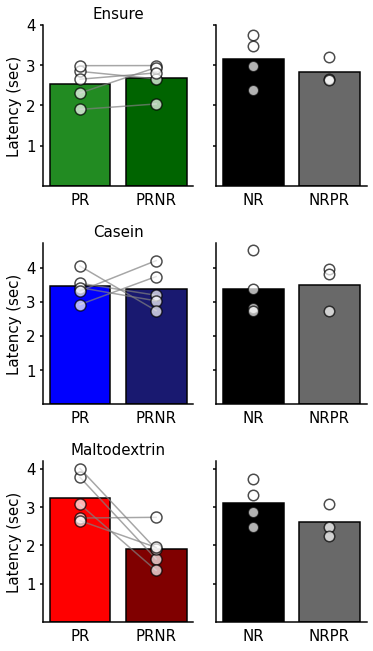

In [44]:
PR_E=['forestgreen','darkgreen']
PR_C=['b','midnightblue']
PR_M=['r','maroon']
NR=['black','dimgray']

f,ax=plt.subplots(figsize=(6,10), ncols=2, nrows=3, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.15)

#Ensure
tp.barscatter([ensure_PR,ensure_PRNR], 
              paired= True,
              barfacecolor=PR_E,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[0,0])

tp.barscatter([ensure_NR,ensure_NRPR], 
#               paired= True,
              barfacecolor=NR,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[0,1])
#casein

tp.barscatter([cas_PR,cas_PRNR], 
              paired= True,
              barfacecolor=PR_C,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[1,0])

tp.barscatter([cas_NR,cas_NRPR], 
#               paired= True,
              barfacecolor=NR,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[1,1])

#maltodextrin

tp.barscatter([malt_PR,malt_PRNR], 
              paired= True,
              barfacecolor=PR_M,
              barlabels=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[2,0])

tp.barscatter([malt_NR,malt_NRPR], 
#               paired= True,
              barfacecolor=NR,
              barlabels=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.7,
              spaced=True,
              linewidth=1.5,
              ax=ax[2,1])



ax[0,0].set_ylabel('Latency (sec)',fontsize = 15)
ax[0,0].set_yticks([10,20,30,40])
ax[0,1].set_yticks([10,20,30,40])
ax[0,0].set_yticklabels([1,2,3,4], fontsize = 15)

ax[1,0].set_ylabel('Latency (sec)',fontsize = 15)
ax[1,0].set_yticks([10,20,30,40])
ax[1,1].set_yticks([10,20,30,40])
ax[1,0].set_yticklabels([1,2,3,4], fontsize = 15)

ax[2,0].set_ylabel('Latency (sec)',fontsize = 15)
ax[2,0].set_yticks([10,20,30,40])
ax[2,1].set_yticks([10,20,30,40])
ax[2,0].set_yticklabels([1,2,3,4], fontsize = 15)

ax[0,0].set_title('Ensure', fontsize =15)
ax[1,0].set_title('Casein', fontsize =15)
ax[2,0].set_title('Maltodextrin', fontsize =15)


f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\Latency.png')

In [45]:
tp.barscatter?

Signature:
tp.barscatter(
    data_in,
    ax=[],
    transpose=False,
    paired=False,
    spaced=False,
    xspace=0.1,
    yspace=20,
    groupwidth=0.75,
    barwidth=0.8,
    barfacecolor_option='same',
    barfacecolor=['white'],
    baredgecolor_option='same',
    baredgecolor=['black'],
    errorbars=False,
    scatteroffset=0,
    scatterfacecolor_option='same',
    scatterfacecolor=['white'],
    scatteredgecolor_option='same',
    scatteredgecolor=['black'],
    scatterlinecolor='grey',
    linewidth=0.75,
    scattersize=80,
    grouplabel=[],
    grouplabeloffset=0,
    barlabels=[],
    barlabeloffset=0.025,
    itemlabels=[],
    show_legend=False,
    legendloc='upper right',
    fontsize=10,
    bar_kwargs={},
    sc_kwargs={'alpha': 0.7, 'linewidth': 1.5, 'zorder': 20, 'clip_on': False},
    ax_kwargs={},
    **extra_kwargs,
)
Docstring: <no docstring>
File:      c:\users\mko102\anaconda3\lib\site-packages\trompy\barscatter.py
Type:      function


In [46]:
plt.subplots_adjust?

Signature:
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=None,
    hspace=None,
)
Docstring:
Adjust the subplot layout parameters.

Unset parameters are left unmodified; initial values are given by
:rc:`figure.subplot.[name]`.

Parameters
----------
left : float, optional
    The position of the left edge of the subplots,
    as a fraction of the figure width.
right : float, optional
    The position of the right edge of the subplots,
    as a fraction of the figure width.
bottom : float, optional
    The position of the bottom edge of the subplots,
    as a fraction of the figure height.
top : float, optional
    The position of the top edge of the subplots,
    as a fraction of the figure height.
wspace : float, optional
    The width of the padding between subplots,
    as a fraction of the average axes width.
hspace : float, optional
    The height of the padding between subplots,
    as a fraction of the average axes height.
File:   